Lorentz Network
===============================================================

Finally we will look at Lorentz-equivariant networks using PyTorch. The architecture is based on the following paper: [Lorentz Group Network](https://arxiv.org/abs/2006.04780)

In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from tqdm.notebook import tqdm
import numpy as np

In [2]:
import yaml

with open('definitions_lgn.yml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)
    
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
ntracks = definitions['ntracks']

## Dataset loader
Here we have to define the dataset loader. 



In [3]:
from LGNDataset import LGNDataset

train_files = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_11.root']
test_files = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_1.root']

train_generator = LGNDataset(features, labels, spectators, n_events=2000, npad = ntracks,
                             file_names=train_files)
train_generator.process()

test_generator = LGNDataset(features, labels, spectators, n_events=1000, npad = ntracks,
                             file_names=test_files)
test_generator.process()

  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/drankin/Documents/iaifi-summer-school/book/LGNDataset.py:109: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1646756029501/work/torch/csrc/utils/tensor_new.cpp:210.)
  x = torch.tensor(fourvec, dtype=torch.float).T


  0%|          | 0/1000 [00:00<?, ?it/s]

## Lorentz Group Networks

The operations in Lorentz Group Networks are constructed from the Clebsch-Gordon coefficients such that they are Lorentz-equivariant. In addition, they are also constructed to be permutation invariant, in a similar manner to the Deep Sets and Interaction Network models we have just seen.

We will define a DeepSets model that will take as input the 4-momentum for up to 60 tracks.

In [4]:
import logging

from lgn.cg_lib import CGModule, ZonalFunctionsRel, ZonalFunctions, normsq4
from lgn.g_lib import GTau

from lgn.models.lgn_cg import LGNCG

from lgn.nn import RadialFilters
from lgn.nn import InputLinear, MixReps
from lgn.nn import OutputLinear, OutputPMLP, GetScalarsAtom
from lgn.nn import NoLayer

#ntracks = 60
inputs = 48
hidden1 = 64
hidden2 = 32
hidden3 = 16
classify1 = 50
outputs = 2


class LGNModel(CGModule):
    """
    Basic LGN Network. Taken from https://github.com/fizisist/LorentzGroupNetwork

    Parameters
    ----------
    maxdim : :obj:`int` of :class:`list` of :class:`int`
        Maximum weight in the output of CG products. (Expanded to list of
        length :obj:`num_cg_levels`)
    max_zf : :class:`int` of :class:`list` of :class:`int`
        Maximum weight in the output of the spherical harmonics  (Expanded to list of
        length :obj:`num_cg_levels`)
    num_cg_levels : :class:`int`
        Number of cg levels to use.
    num_channels : :class:`int` of :class:`list` of :class:`int`
        Number of channels that the output of each CG are mixed to (Expanded to list of
        length :obj:`num_cg_levels`)
    num_species : :class:`int`
        Number of species of atoms included in the input dataset.
    device : :class:`torch.device`
        Device to initialize the level to
    dtype : :class:`torch.torch.dtype`
        Data type to initialize the level to level to
    cg_dict : :class:`CGDict <lgn.cg_lib.CGDict>`
        Clebsch-gordan dictionary object.
    """
    def __init__(self, maxdim, max_zf, num_cg_levels, num_channels,
                 cutoff_type, hard_cut_rad, soft_cut_rad, soft_cut_width,
                 weight_init, level_gain, num_basis_fn,
                 top, input, num_mpnn_layers, activation='leakyrelu', pmu_in=False, add_beams=True,
                 scale=1, full_scalars=False, mlp=True, mlp_depth=None, mlp_width=None,
                 device=torch.device('cpu'), dtype=None, cg_dict=None):
        

        logging.info('Initializing network!')
        level_gain = expand_var_list(level_gain, num_cg_levels)

        hard_cut_rad = expand_var_list(hard_cut_rad, num_cg_levels)
        soft_cut_rad = expand_var_list(soft_cut_rad, num_cg_levels)
        soft_cut_width = expand_var_list(soft_cut_width, num_cg_levels)

        maxdim = expand_var_list(maxdim, num_cg_levels)
        max_zf = expand_var_list(max_zf, num_cg_levels)
        num_channels = expand_var_list(num_channels, num_cg_levels + 1)

        logging.info('hard_cut_rad: {}'.format(hard_cut_rad))
        logging.info('soft_cut_rad: {}'.format(soft_cut_rad))
        logging.info('soft_cut_width: {}'.format(soft_cut_width))
        logging.info('maxdim: {}'.format(maxdim))
        logging.info('max_zf: {}'.format(max_zf))
        logging.info('num_channels: {}'.format(num_channels))

        super().__init__(maxdim=max(maxdim + max_zf), device=device, dtype=dtype, cg_dict=cg_dict)
        device, dtype, cg_dict = self.device, self.dtype, self.cg_dict

        logging.info('CGdict maxdim: {}'.format(cg_dict.maxdim))

        self.num_cg_levels = num_cg_levels
        self.num_channels = num_channels
        self.scale = scale
        self.full_scalars = full_scalars
        self.pmu_in = pmu_in

        # Set up spherical harmonics
        if pmu_in:
            self.zonal_fns_in = ZonalFunctions(max(max_zf), device=device, dtype=dtype, cg_dict=cg_dict)
        self.zonal_fns = ZonalFunctionsRel(max(max_zf), device=device, dtype=dtype, cg_dict=cg_dict)

        # Set up position functions, now independent of spherical harmonics
        self.rad_funcs = RadialFilters(max_zf, num_basis_fn, num_channels, num_cg_levels, device=self.device, dtype=self.dtype)
        tau_pos = self.rad_funcs.tau

        if num_cg_levels:
            if add_beams:
                num_scalars_in = 2
            else:
                num_scalars_in = 1
        else:
            num_scalars_in = 202  # the second number should match the number of atoms (including beams)

        num_scalars_out = num_channels[0]

        if not pmu_in:
            self.input_func_atom = InputLinear(num_scalars_in, num_scalars_out,
                                               device=self.device, dtype=self.dtype)
        else:
            self.input_func_atom = MixReps(GTau({**{(0,0): num_scalars_in},**{(l,l): 1 for l in range(1, max_zf[0] + 1)}}), 
                                           GTau({(l,l): num_scalars_out for l in range(max_zf[0] + 1)}),
                                           device=self.device, dtype=self.dtype)
        
        tau_in_atom = self.input_func_atom.tau

        self.lgn_cg = LGNCG(maxdim, max_zf, tau_in_atom,
                                        tau_pos, num_cg_levels, num_channels,
                                        level_gain, weight_init, cutoff_type,
                                        hard_cut_rad, soft_cut_rad, soft_cut_width,
                                        mlp=mlp, mlp_depth=mlp_depth, mlp_width=mlp_width,
                                        activation=activation, device=self.device, dtype=self.dtype, cg_dict=self.cg_dict)

        tau_cg_levels_atom = self.lgn_cg.tau_levels_atom

        self.get_scalars_atom = GetScalarsAtom(tau_cg_levels_atom,
                                               device=self.device, dtype=self.dtype)

        num_scalars_atom = self.get_scalars_atom.num_scalars

        if top.lower().startswith('lin'):
            self.output_layer_atom = OutputLinear(num_scalars_atom, bias=True,
                                                  device=self.device, dtype=self.dtype)
        elif top.lower().startswith('pmlp'):
            self.output_layer_atom = OutputPMLP(num_scalars_atom, num_mixed=mlp_width,
                                                  device=self.device, dtype=self.dtype)

        logging.info('Model initialized. Number of parameters: {}'.format(sum(p.nelement() for p in self.parameters())))

    def forward(self, data, covariance_test=False):
        """
        Runs a forward pass of the network.

        Parameters
        ----------
        data : :obj:`dict`
            Dictionary of data to pass to the network.
        covariance_test : :obj:`bool`, optional
            If true, returns all of the atom-level representations twice.

        Returns
        -------
        prediction : :obj:`torch.Tensor`
            The output of the layer
        """
        # Get and prepare the data
        atom_scalars, atom_mask, edge_mask, atom_ps = self.prepare_input(data, self.num_cg_levels)

        # Calculate spherical harmonics and radial functions
        if self.pmu_in:
            zonal_functions_in, _, _ = self.zonal_fns_in(atom_ps)
            zonal_functions_in[(0, 0)] = torch.stack([atom_scalars.unsqueeze(-1),torch.zeros_like(atom_scalars.unsqueeze(-1))])
        zonal_functions, norms, sq_norms = self.zonal_fns(atom_ps, atom_ps)

        # Prepare the input reps for both the atom and edge network
        if self.num_cg_levels > 0:
            rad_func_levels = self.rad_funcs(norms, edge_mask * (norms != 0).byte())
            if not self.pmu_in:
                atom_reps_in = self.input_func_atom(atom_scalars, atom_mask)
            else:
                atom_reps_in = self.input_func_atom(zonal_functions_in)
        else:
            rad_func_levels = []
            atom_reps_in = self.input_func_atom(atom_scalars, atom_mask)

        # edge_net_in = self.input_func_edge(atom_scalars, atom_mask, edge_scalars, edge_mask, norms, sq_norms)

        # Clebsch-Gordan layers central to the network
        atoms_all = self.lgn_cg(atom_reps_in, atom_mask, rad_func_levels, zonal_functions)
        # Construct scalars for network output
        atom_scalars = self.get_scalars_atom(atoms_all)
        # edge_scalars = self.get_scalars_edge(edges_all)
        # Prediction in this case will depend only on the atom_scalars. Can make
        # it more general here.
        prediction = self.output_layer_atom(atom_scalars, atom_mask)

        # Covariance test
        if covariance_test:
            return prediction, atoms_all
        else:
            return prediction

    def prepare_input(self, data, cg_levels=True):
        """
        Extracts input from data class

        Parameters
        ----------
        data : ?????
            Information on the state of the system.

        Returns
        -------
        atom_scalars : :obj:`torch.Tensor`
            Tensor of scalars for each atom.
        atom_mask : :obj:`torch.Tensor`
            Mask used for batching data.
        atom_ps: :obj:`torch.Tensor`
            Positions of the atoms
        edge_mask: :obj:`torch.Tensor`
            Mask used for batching data.
        """
        device, dtype = self.device, self.dtype

        atom_ps = data['Pmu'].to(device, dtype) * self.scale

        data['Pmu'].requires_grad_(True)
        atom_mask = data['atom_mask'].to(device, torch.uint8)
        edge_mask = data['edge_mask'].to(device, torch.uint8)

        scalars = torch.ones_like(atom_ps[:, :, 0]).unsqueeze(-1)
        scalars = normsq4(atom_ps).abs().sqrt().unsqueeze(-1)

        if 'scalars' in data.keys():
            scalars = torch.cat([scalars, data['scalars'].to(device, dtype)], dim=-1)

        if not cg_levels:
            scalars = torch.stack(tuple(scalars for _ in range(scalars.shape[-1])), -2)

        return scalars, atom_mask, edge_mask, atom_ps


def expand_var_list(var, num_cg_levels):
    if type(var) is list:
        var_list = var + (num_cg_levels - len(var)) * [var[-1]]
    elif type(var) in [float, int]:
        var_list = [var] * num_cg_levels
    else:
        raise ValueError('Incorrect type {}'.format(type(var)))
    return var_list


model = LGNModel(maxdim=3, 
                 max_zf=1, 
                 num_cg_levels=3, 
                 num_channels=[2,4,4,2], 
                 cutoff_type=['learn'],
                 hard_cut_rad=np.inf,
                 soft_cut_rad=np.inf,
                 soft_cut_width=np.inf,
                 weight_init='randn',
                 level_gain=[1.],
                 num_basis_fn=10,
                 top='linear', 
                 input='linear', 
                 num_mpnn_layers=1,
                 mlp=True,
                 mlp_width=2,
                 mlp_depth=3,
                 pmu_in=False,
                 add_beams=False,
                 device=device)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-1)

print(model)
print('----------')
print({l:model.state_dict()[l].shape for l in model.state_dict()})

gen_cg_dict called with maxdim = 3
LGNModel(
  (zonal_fns): ZonalFunctionsRel()
  (rad_funcs): RadialFilters(
    (rad_funcs): ModuleList(
      (0): RadPolyTrig(
        (linear): ModuleList(
          (0): Linear(in_features=20, out_features=4, bias=True)
          (1): Linear(in_features=20, out_features=4, bias=True)
        )
      )
      (1): RadPolyTrig(
        (linear): ModuleList(
          (0): Linear(in_features=20, out_features=8, bias=True)
          (1): Linear(in_features=20, out_features=8, bias=True)
        )
      )
      (2): RadPolyTrig(
        (linear): ModuleList(
          (0): Linear(in_features=20, out_features=8, bias=True)
          (1): Linear(in_features=20, out_features=8, bias=True)
        )
      )
    )
  )
  (input_func_atom): InputLinear(
    (lin): Linear(in_features=1, out_features=4, bias=True)
  )
  (lgn_cg): LGNCG(
    (atom_levels): ModuleList(
      (0): LGNAtomLevel(
        (cg_aggregate): CGProduct()
        (cg_power): CGProduct()
    

## Define training loop

In [5]:
@torch.no_grad()
def test(model, loader, total, batch_size, leave=False):
    model.eval()
    
    xentropy = nn.CrossEntropyLoss(reduction='mean')

    sum_loss = 0.
    t = tqdm(enumerate(loader), total=total/batch_size, leave=leave)
    for i, data in t:
        #x = data['Pmu'].to(device)
        y = data['output'].to(device)
        y = torch.argmax(y, dim=1)
        data['atom_mask'] = torch.ones(data['Pmu'].size()[:2], dtype=torch.uint8)
        data['atom_mask'][data['Pmu'][:,:,0]==0] = 0
        data['edge_mask'] = torch.ones(data['Pmu'].size(dim=1), dtype=torch.uint8)
        batch_output = model(data)
        batch_loss_item = xentropy(batch_output, y).item()
        sum_loss += batch_loss_item
        t.set_description("loss = %.5f" % (batch_loss_item))
        t.refresh() # to show immediately the update

    return sum_loss/(i+1)

def train(model, optimizer, loader, total, batch_size, leave=False):
    model.train()
    
    xentropy = nn.CrossEntropyLoss(reduction='mean')

    sum_loss = 0.
    t = tqdm(enumerate(loader), total=total/batch_size, leave=leave)
    for i, data in t:
        #x = data['Pmu'].to(device)
        y = data['output'].to(device)
        y = torch.argmax(y, dim=1)
        optimizer.zero_grad()
        data['atom_mask'] = torch.ones(data['Pmu'].size()[:2], dtype=torch.uint8)
        data['atom_mask'][data['Pmu'][:,:,0]==0] = 0
        data['edge_mask'] = torch.ones(data['Pmu'].size(dim=1), dtype=torch.uint8)
        batch_output = model(data)
        batch_loss = xentropy(batch_output, y)
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        t.set_description("loss = %.5f" % batch_loss_item)
        t.refresh() # to show immediately the update
        sum_loss += batch_loss_item
        optimizer.step()
    
    return sum_loss/(i+1)

## Define training, validation, testing data generators

In [6]:
from torch.utils.data import ConcatDataset
from LGNDataset import PmuDataset
train_generator_data = {c:ConcatDataset(train_generator.datas[c]) for c in train_generator.datas}
test_generator_data = {c:ConcatDataset(test_generator.datas[c]) for c in test_generator.datas}
train_generator_data = PmuDataset(x=train_generator_data['x'], 
                                  y=train_generator_data['y'])
test_generator_data = PmuDataset(x=test_generator_data['x'], 
                                  y=test_generator_data['y'])

In [7]:
from torch.utils.data import random_split, DataLoader

torch.manual_seed(0)
valid_frac = 0.20
train_length = len(train_generator_data)
valid_num = int(valid_frac*train_length)
batch_size = 32

train_dataset, valid_dataset = random_split(train_generator_data, [train_length-valid_num,valid_num])

def collate(items):
    l = sum(items, [])
    return Batch.from_data_list(l)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#train_loader.collate_fn = collate
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
#valid_loader.collate_fn = collate
test_loader = DataLoader(test_generator_data, batch_size=batch_size, shuffle=False)
#test_loader.collate_fn = collate

train_samples = len(train_dataset)
valid_samples = len(valid_dataset)
test_samples = len(test_generator_data)
print(train_length)
print(train_samples)
print(valid_samples)
print(test_samples)

1881
1505
376
949


## Train

In [8]:
import torch.nn as nn
import os.path as osp

n_epochs = 2
stale_epochs = 0
best_valid_loss = 99999
patience = 5
t = tqdm(range(0, n_epochs))

for epoch in t:
    loss = train(model, optimizer, train_loader, train_samples, batch_size, leave=bool(epoch==n_epochs-1))
    valid_loss = test(model, valid_loader, valid_samples, batch_size, leave=bool(epoch==n_epochs-1))
    print('Epoch: {:02d}, Training Loss:   {:.4f}'.format(epoch, loss))
    print('           Validation Loss: {:.4f}'.format(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        modpath = osp.join('lgn_best.pth')
        print('New best model saved to:',modpath)
        torch.save(model.state_dict(),modpath)
        stale_epochs = 0
    else:
        print('Stale epoch')
        stale_epochs += 1
    if stale_epochs >= patience:
        print('Early stopping after %i stale epochs'%patience)
        break

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/47.03125 [00:00<?, ?it/s]

/Users/drankin/Documents/iaifi-summer-school/book/lgn/nn/position_levels.py:140: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1646756029501/work/aten/src/ATen/native/TensorCompare.cpp:333.)
  rad_trig = torch.where(edge_mask, self.b * (torch.ones_like(self.b) + (self.c * norms).pow(2)).pow(-1) + self.a, self.zero).unsqueeze(-1)


  0%|          | 0/11.75 [00:00<?, ?it/s]

Epoch: 00, Training Loss:   723258351979158175744.0000
           Validation Loss: 431602350075780202496.0000
Stale epoch


  0%|          | 0/47.03125 [00:00<?, ?it/s]

  0%|          | 0/11.75 [00:00<?, ?it/s]

Epoch: 01, Training Loss:   19120506426929730027520.0000
           Validation Loss: 340237936768752877568.0000
Stale epoch


## Evaluate on testing data

In [9]:
model.eval()
t = tqdm(enumerate(test_loader),total=test_samples/batch_size)
y_test = []
y_predict = []
for i,data in t:
    #x = data['Pmu'].to(device)
    y = data['output'].to(device)
    data['atom_mask'] = torch.ones(data['Pmu'].size()[:2], dtype=torch.uint8)
    data['atom_mask'][data['Pmu'][:,:,0]==0] = 0
    data['edge_mask'] = torch.ones(data['Pmu'].size(dim=1), dtype=torch.uint8)
    batch_output = model(data)    
    y_predict.append(batch_output.detach().cpu().numpy())
    y_test.append(y.cpu().numpy())
y_test = np.concatenate(y_test)
y_predict = np.concatenate(y_predict)

  0%|          | 0/29.65625 [00:00<?, ?it/s]

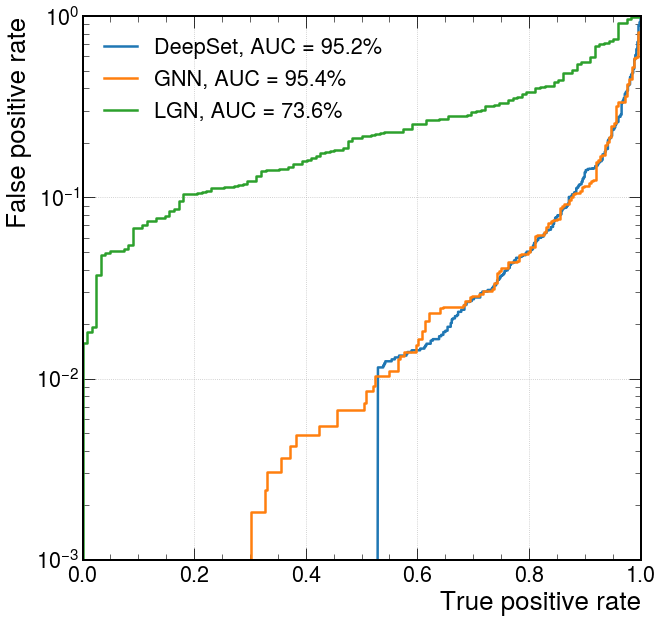

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)
# create ROC curves
fpr_lgn, tpr_lgn, threshold_lgn = roc_curve(y_test[:,1], y_predict[:,1])
with open('lgn_roc.npy', 'wb') as f:
    np.save(f, fpr_lgn)
    np.save(f, tpr_lgn)
    np.save(f, threshold_lgn)
    
with open('gnn_roc.npy', 'rb') as f:
    fpr_gnn = np.load(f)
    tpr_gnn = np.load(f)
    threshold_gnn = np.load(f)

with open('deepset_roc.npy', 'rb') as f:
    fpr_deepset = np.load(f)
    tpr_deepset = np.load(f)
    threshold_deepset = np.load(f)
    
# plot ROC curves
plt.figure()
plt.plot(tpr_deepset, fpr_deepset, lw=2.5, label="DeepSet, AUC = {:.1f}%".format(auc(fpr_deepset,tpr_deepset)*100))
plt.plot(tpr_gnn, fpr_gnn, lw=2.5, label="GNN, AUC = {:.1f}%".format(auc(fpr_gnn,tpr_gnn)*100))
plt.plot(tpr_lgn, fpr_lgn, lw=2.5, label="LGN, AUC = {:.1f}%".format(auc(fpr_lgn,tpr_lgn)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()